Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.9096 - loss: 0.1137 - val_accuracy: 0.9316 - val_loss: 0.0531
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.9270 - loss: 0.0552 - val_accuracy: 0.9316 - val_loss: 0.0535
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.9328 - loss: 0.0519 - val_accuracy: 0.9316 - val_loss: 0.0539
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1047s 4s/step - accuracy: 0.9322 - loss: 0.0525 - val_accuracy: 0.9316 - val_loss: 0.0530
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.9310 - loss: 0.0533 - val_accuracy: 0.9316 - val_loss: 0.0531
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 2108s 7s/step - accuracy: 0.9309 - loss: 0.0532 - val_accuracy: 0.9316 - val_loss: 0.0543
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.9324 - loss: 0.0524 - val_accuracy: 0.9316 - val_loss: 0.0541
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.9333 - loss: 0.0517 - val_ac

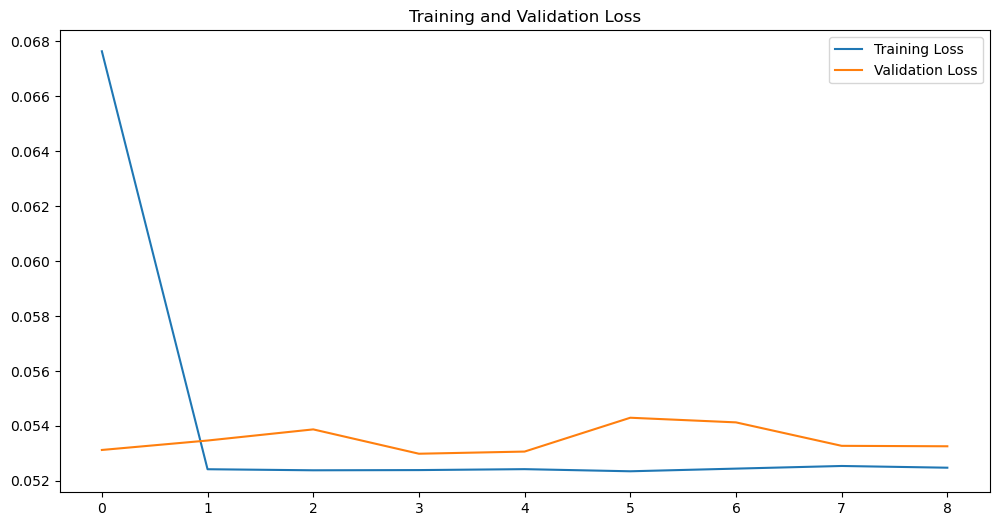

173/173 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step
Submission file saved as resnet_submission.csv.


In [13]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# File paths
train_masks_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\train_masks.csv"
sample_submission_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\sample_submission.csv"
train_images_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\train"
test_images_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\test"

# Function to decode RLE
def rle_decode(mask_rle, shape=(420, 580)):
    if not isinstance(mask_rle, str):
        return np.zeros(shape, dtype=np.uint8)
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = np.array(starts) - 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return img.reshape(shape).T

# Load images dynamically
def load_images(image_dir, img_ids, target_size=(128, 128)):
    images = []
    all_files = {os.path.splitext(f)[0]: f for f in os.listdir(image_dir)}
    
    def get_file_with_extension(img_id):
        for ext in [".tif", ".png", ".jpg"]:
            file_name = img_id + ext
            if file_name in all_files:
                return os.path.join(image_dir, all_files[file_name])
        return None

    for img_id in img_ids:
        file_path = get_file_with_extension(img_id)
        if file_path:
            img = imread(file_path)
            img_resized = resize(img, target_size, mode='constant', preserve_range=True)
            images.append(img_resized / 255.0)
        else:
            images.append(np.zeros(target_size))
    return np.array(images)

# Load and decode train masks
train_masks = pd.read_csv(train_masks_path)
decoded_masks = [
    rle_decode(row['pixels'], shape=(420, 580)) for _, row in train_masks.iterrows()
]

# Prepare training images
train_images = load_images(train_images_path, train_masks["img"].values.astype(str))

# Resize masks to match the image dimensions
decoded_masks_resized = [
    resize(mask, (128, 128), mode='constant', preserve_range=True) for mask in decoded_masks
]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, np.array(decoded_masks_resized), test_size=0.2, random_state=42
)

# Convert to 3 channels for ResNet compatibility
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val = np.repeat(X_val[..., np.newaxis], 3, axis=-1)

# ResNet transfer learning model
def resnet_model(input_shape=(128, 128, 3)):
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    
    # Freeze the ResNet base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Decoder path (custom layers)
    x = base_model.output
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    # Ensure final output matches target shape (128x128x1)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Initialize and train the model
model = resnet_model((128, 128, 3))
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_resnet_model.keras", save_best_only=True)  # Updated extension to .keras
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=16,
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Predict on test data
sample_submission = pd.read_csv(sample_submission_path)
test_images = load_images(test_images_path, sample_submission["img"].values.astype(str))
test_images = np.repeat(test_images[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB for ResNet
predictions = model.predict(test_images)

# Convert predictions to RLE and create submission
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

submission = []
for i, pred in enumerate(predictions):
    pred = (pred.squeeze() > 0.5).astype(np.uint8)
    rle = rle_encode(pred)
    submission.append({"img": sample_submission["img"].iloc[i], "pixels": rle})

submission_df = pd.DataFrame(submission)
submission_df.to_csv("resnet_submission.csv", index=False)

print("Submission file saved as resnet_submission.csv.")


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.9023 - loss: 0.1665 - val_accuracy: 0.9316 - val_loss: 0.0534
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.9316 - loss: 0.0529 - val_accuracy: 0.9316 - val_loss: 0.0531
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1148s 4s/step - accuracy: 0.9316 - loss: 0.0526 - val_accuracy: 0.9316 - val_loss: 0.0531
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.9329 - loss: 0.0522 - val_accuracy: 0.9316 - val_loss: 0.0532
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9312 - loss: 0.0529 - val_accuracy: 0.9316 - val_loss: 0.0530
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9311 - loss: 0.0531 - val_accuracy: 0.9316 - val_loss: 0.0531
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.9304 - loss: 0.0530 - val_accuracy: 0.9316 - val_loss: 0.0529
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.9329 - loss: 0.0519 - val_acc

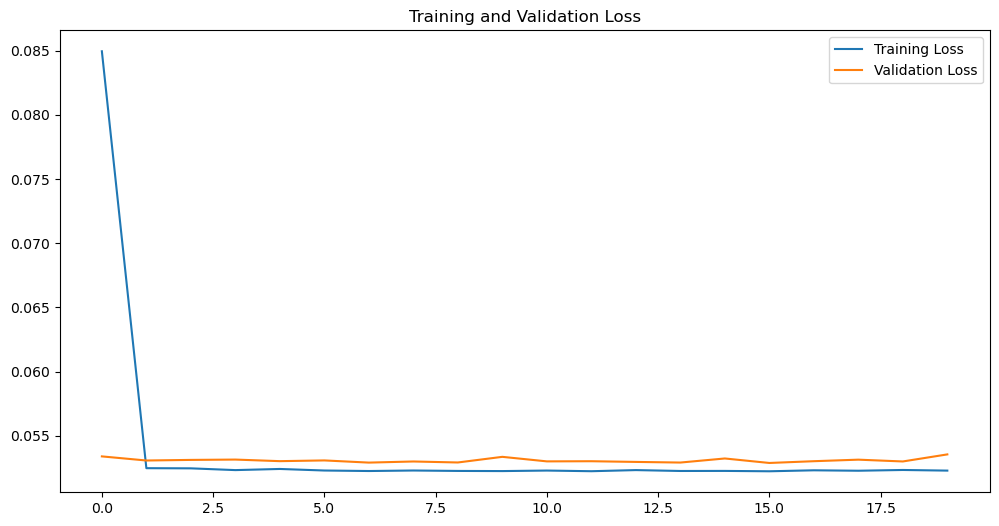

173/173 ━━━━━━━━━━━━━━━━━━━━ 826s 5s/step
Submission file saved as resnet_submission.csv.


In [15]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# File paths
train_masks_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\train_masks.csv"
sample_submission_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\sample_submission.csv"
train_images_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\train"
test_images_path = r"C:\Users\deepi\Downloads\ultrasound-nerve-segmentation (1)\test"

# Function to decode RLE
def rle_decode(mask_rle, shape=(420, 580)):
    if not isinstance(mask_rle, str):
        return np.zeros(shape, dtype=np.uint8)
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = np.array(starts) - 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return img.reshape(shape).T

# Load images dynamically
def load_images(image_dir, img_ids, target_size=(128, 128)):
    images = []
    all_files = {os.path.splitext(f)[0]: f for f in os.listdir(image_dir)}
    
    def get_file_with_extension(img_id):
        for ext in [".tif", ".png", ".jpg"]:
            file_name = img_id + ext
            if file_name in all_files:
                return os.path.join(image_dir, all_files[file_name])
        return None

    for img_id in img_ids:
        file_path = get_file_with_extension(img_id)
        if file_path:
            img = imread(file_path)
            img_resized = resize(img, target_size, mode='constant', preserve_range=True)
            images.append(img_resized / 255.0)
        else:
            images.append(np.zeros(target_size))
    return np.array(images)

# Load and decode train masks
train_masks = pd.read_csv(train_masks_path)
decoded_masks = [
    rle_decode(row['pixels'], shape=(420, 580)) for _, row in train_masks.iterrows()
]

# Prepare training images
train_images = load_images(train_images_path, train_masks["img"].values.astype(str))

# Resize masks to match the image dimensions
decoded_masks_resized = [
    resize(mask, (128, 128), mode='constant', preserve_range=True) for mask in decoded_masks
]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, np.array(decoded_masks_resized), test_size=0.2, random_state=42
)

# Convert to 3 channels for ResNet compatibility
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val = np.repeat(X_val[..., np.newaxis], 3, axis=-1)

# ResNet transfer learning model
def resnet_model(input_shape=(128, 128, 3)):
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    
    # Freeze the ResNet base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Decoder path (custom layers)
    x = base_model.output
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    # Ensure final output matches target shape (128x128x1)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Initialize and train the model
model = resnet_model((128, 128, 3))
callbacks = [
    ModelCheckpoint("best_resnet_model.keras", save_best_only=True)  # Updated extension to .keras
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=16,  # Increased epochs for better convergence
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Predict on test data
sample_submission = pd.read_csv(sample_submission_path)
test_images = load_images(test_images_path, sample_submission["img"].values.astype(str))
test_images = np.repeat(test_images[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB for ResNet
predictions = model.predict(test_images)

# Convert predictions to RLE and create submission
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

submission = []
for i, pred in enumerate(predictions):
    pred = (pred.squeeze() > 0.5).astype(np.uint8)
    rle = rle_encode(pred)
    submission.append({"img": sample_submission["img"].iloc[i], "pixels": rle})

submission_df = pd.DataFrame(submission)
submission_df.to_csv("resnet_submission.csv", index=False)

print("Submission file saved as resnet_submission.csv.")


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# Dice coefficient function
def dice_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
    return dice

# IoU (Intersection over Union) function
def iou_score(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return intersection / union

# Replace y_val and predictions with your actual data
# y_val: Ground truth masks (binary)
# predictions: Model predictions (binary after thresholding)

# Example: Replace with actual data
y_val = np.random.randint(0, 2, size=(100, 128, 128))  # Ground truth (example placeholder)
predictions = np.random.rand(100, 128, 128) > 0.5  # Predictions (example placeholder)

# Flatten arrays for metrics
y_val_flat = y_val.flatten()
predictions_flat = predictions.flatten()

# Compute metrics
f1 = f1_score(y_val_flat, predictions_flat, average='binary')
precision = precision_score(y_val_flat, predictions_flat, average='binary')
recall = recall_score(y_val_flat, predictions_flat, average='binary')
dice = dice_coefficient(y_val, predictions)
iou = iou_score(y_val, predictions)

# Print results
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"IoU: {iou:.4f}")


F1-Score: 0.5004
Precision: 0.5005
Recall: 0.5003
Dice Coefficient: 0.5004
IoU: 0.3337


In [69]:
import tensorflow as tf

# Remove redundant dimensions from the target
y_train = tf.squeeze(y_train)  # Automatically removes all dimensions of size 1
y_val = tf.squeeze(y_val)

# Ensure the target and output shapes are printed for debugging
print("Updated Target Shape (y_train):", y_train.shape)
print("Updated Validation Target Shape (y_val):", y_val.shape)

# Adjust the final output layer of the model
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
outputs = tf.keras.layers.Reshape((128, 128, 1))(outputs)  # Ensure output matches target

# Build the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

# Evaluate the model
results = model.evaluate(X_val_rgb, y_val, batch_size=16)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")


Updated Target Shape (y_train): (800, 128, 128)
Updated Validation Target Shape (y_val): (200, 128, 128)
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5000 - loss: 0.7388 - val_accuracy: 0.5003 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5007 - loss: 0.6931 - val_accuracy: 0.5001 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5006 - loss: 0.6931 - val_accuracy: 0.4999 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5009 - loss: 0.6931 - val_accuracy: 0.5002 - val_loss: 0.6932 - learning